In [33]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import copy
from sklearn.preprocessing import MinMaxScaler
from typing import Union, Dict, Any, Tuple, List
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report

The dataset is downloaded from Kaggle. [Here](https://www.kaggle.com/datasets/nancyalaswad90/breast-cancer-dataset/data) you can find where I downloaded the dataset.

In [34]:
data = pd.read_csv("data/brest_cancer_data.csv")

In [35]:
data.shape

(569, 33)

In [36]:
data.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')

As we can see the dataset has 569 tumor samples and 32 columns. We are going to use the 'diagnosis' column as the label, and other columns such as 'radius_mean','texture_mean',etc as the features to make the classification. Our goal is classify the given tumors into malignant (cancerous) or benign(non-cancerous). 

Lets create labels from diagnosis column of our dataset. We are going to use 0 for the 'benign' class and 1 for the 'malignant' class. 

In [37]:
labels = [0 if x == "B" else 1 for x in data.diagnosis]
print(len(labels))

569


Now lets drop the columns which we are not going to use as features. We are going to drop 'id' because it hasn't relevant information to decide if a tumor is malignant or bening. Also we are going to drop diagnosis column because it is not a feature it is something that we want to predict.

In [38]:
data.drop(["id", "diagnosis", "Unnamed: 32"], axis=1, inplace=True)

# Scaling the inputs
Having features at the same scale helps the model produce more stable and reliable results. Features at different scales can cause the model to overweight some features, which can degrade the overall performance. Proper scaling can improve model performance, reduce training time, and help you achieve better results overall. Because with features in different ranges, our cost function has a more extended elliptical structure and a more oscillatory path can be followed to reach its minimum value, but with normalized features, cost has a more symmetric structure and the minimum point can be reached more directly.
<img src="image_files/scaled_vs_unscaled_inputs.png" style="width:390px;height:240px;">
Original image was taken from [Improving Deep Neural Networks: Hyperparameter Tuning, Regularization and Optimization](https://www.coursera.org/learn/deep-neural-network) course of Andrew NG. I modified the image little bit. 
To make our learning algorithm work more effectively let's scale our data. We are going to use 'MinMaxScaler' from sklearn.preprocessing library. MinMaxScaler scales the data in the range of [0,1], it only changes the scale of the data, preserving its original distribution. This allows us to scale without disturbing the structure and distribution of the data. [Here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) you can find the original documentation of the MinMaxScaler if you are curious about it's details.

In [56]:
scaler = MinMaxScaler()
scaler.fit(data)
data = scaler.transform(data)

Let's split our data into the training data and the test data as the first step. We are going to use 80% of the data for training, and rest of it for the testing.

In [57]:
train_data_size = int(data.shape[0] * 0.8)
training_data = data[:train_data_size]
X_train = training_data.T
test_data = data[train_data_size:]
X_test = test_data.T
Y_train = np.array(labels[:train_data_size])
Y_test = np.array(labels[train_data_size:])
print("Shape of the training data: ", X_train.shape)
print("Shape of the test data: ", X_test.shape)
print("Shape of the training labels: ", Y_train.shape)
print("Shape of the test labels: ", Y_test.shape)

Shape of the training data:  (30, 455)
Shape of the test data:  (30, 114)
Shape of the training labels:  (455,)
Shape of the test labels:  (114,)


Now we have a training dataset which is an array of 30 rows and 455 columns, and test dataset which is an array of 30 rows and 114 columns. Each row represent a feature and each column represent a tumor sample from our dataset.

Our data is ready for training and test purposes.
Now let's crate some helper functions.

 # Architecture of our learning algorithm
Let's design our simple learning algorithm to classify tumors as 'malignant' or 'benign'.
<img src="image_files/architecture.png" style="width:718px;height:300px;">

## Notations
* $ ^{(i)}$: Denotes i'th sample from our dataset. For example $ x^{(3)}$ denotes 3rd sample from our dataset.
* $m$: Denotes total number of samples we have in our dataset.
* $_{i}$: Denotes i'th feature of the sample, or i'th parameter of the parameters. For example: $X^{(5)}_{3}$ denotes 3rd feature of 5th sample from our dataset. $w_{3}$ denotes 3rd parameter of parameters.
* $L$: Loss .
* $J$: Cost. 
* $\alpha$: Learning rate.

## Mathematical expressions
* $z^{(i)} = w^T x^{(i)} + b$
* $a^{(i)} = sigmoid(z^{(i)})$
* $\mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})$
* $ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})$

Cost is calculated by averaging the losses of each sample.

## Steps of our learning algorithm.
  1) Initialize parameters.
  
  2) Forward propagation.
   * Compute $z^{(i)}$ and $a^{(i)}$ by using inputs and parameters.
  
  
  3) Compute Cost
    
    
  4) Backward propagation
   * Compute gradients by using the cost. 
    * $d_{w} = \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T$
    * $d_{b} = \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})$
   * Update parameters by using the gradients.
    * $ w = w - \alpha * d_{w}$
    * $ b = b - \alpha * d_{b}$
  
  5) Make predictions on test data by using learned parameters.

# Initialization of parameters
Since we single neuron for our logistic regression problem, we can initialize our parameters with zeroes because it can not cause any symetry problem which we don't want to have.

In [58]:
def initialize_parameters(dim: int) -> Tuple[np.array, float]:
    """
    This function is initialize parameters 'w' and 'b'.
    Args:
    dim(int) -- dimension of the vector which we want to create.(number of the parameters)

    Returns:
    (Tuple[np.array,float]): w and b. W is a vector of zeroes with shape (dim, 1) and
                             b is a scalar(bias).
    """
    w = np.zeros((dim, 1))
    b = 0.0
    return w, b

In [59]:
w, b = initialize_parameters(3)
print("Shape of w = ", w.shape)
print("w = ", w)
print("b = ", b)

Shape of w =  (3, 1)
w =  [[0.]
 [0.]
 [0.]]
b =  0.0


# Activation Function
As we mentioned before, we will try to classify each tumor as 'benign' or 'malignant' with given its features.
Since we have 2 classes in our classification problem, we can use the sigmoid function as the activation function.
<img src="image_files/sigmoid_function.png" style="width:325px;height:200px;">


In [60]:
def compute_sigmoid(z: Union[int, float, np.array]) -> Union[float, np.array]:
    """
    This function computes the sigmoid of given input.

    Args:
        z(Union[int,float,np.array]): A scalar value or a numpy array.
    Return:
        (Union[float,np.array]):  computed sigmoid of the given input.
                                  Float if the input is a scalar valye,
                                  np.array if the given input is an array.
    """
    # sigmoid(z) = 1/(1+(e)^-z)
    return 1 / (1 + np.exp(-z))

In [61]:
input_1 = 0
input_2 = 7.5
input_3 = np.array([-3, 0, 2])
print(f"Sigmoid of {input_1} is: ", compute_sigmoid(input_1))
print(f"Sigmoid of {input_2} is: ", compute_sigmoid(input_2))
print(f"Sigmoid of {input_3} is: ", compute_sigmoid(input_3))

Sigmoid of 0 is:  0.5
Sigmoid of 7.5 is:  0.9994472213630764
Sigmoid of [-3  0  2] is:  [0.04742587 0.5        0.88079708]


In [62]:
def forward_propagation(weights: np.array, bias: float, X: np.array) -> np.array:
    """
    This function created to propagate forword in our learning algorithm.
    Takes transpose of the weights, dot product it with X, and add bias to compute Z. After that uses
    sigmoid function as the activation function to compute A.
        Z = np.dot(weights.T,X)+bias
        A = sigmoid(Z)
    Args:
        weights(np.array): Array with shape of (features,1) which will be used to compute Z.
        bias(float): A scalar value as bias.
        X(np.array): Array which contain tumor samples from our dataset Shape=(features,samples).
    Return:
        (np.array):  Sigmoid of Z Shape =(1,features).
    """
    Z = np.dot(weights.T, X) + bias
    A = compute_sigmoid(Z.astype(float))
    return A

In [46]:
def compute_cost(A: np.array, Y: np.array) -> float:
    """
    This function created to compute cost from given inputs(predictions and grand truth labels).

    Args:
        A(np.array): Predicted values(0<a<1) which we get from forward propagation.
        Y(np.array): Grand truth classes. 0 for bening tumors 1 for malignant tumors.

    Return:
        (float):  computed cost.
    """
    m = A.shape[1]
    loses = -np.dot(Y, np.log(A).T) - np.dot(1 - Y, np.log(1 - A).T)
    cost = np.sum(loses) / m
    return cost

In [47]:
def backward_propagation(
    A: np.array,
    X: np.array,
    Y: np.array,
    weights: np.array,
    bias: float,
    learning_rate: float,
) -> Tuple[np.array, float]:
    """
    This function created to compute gradients and update parameters(weights and bias) based of computed
    gradients.

    Args:
        A(np.array): Predicted values(0<a<1) which we get from forward propagation. Shape=(1,num_samples)
        Y(np.array): Grand truth classes. 0 for bening tumors 1 for malignant tumors.
        X(np.array): dataset with shape of (num_features,num_samples).
        weights(np.array): Array with shape of (num_features,1)
    Return:
        (float):  computed cost.
    """
    w = copy.deepcopy(weights)
    b = copy.deepcopy(bias)
    m = X.shape[1]
    dw = np.dot(X, (A - Y).T) / m
    db = np.sum(A - Y) / m
    # Update weights
    weights = w - learning_rate * dw
    bias = b - learning_rate * db
    return weights, bias

In [48]:
def train(
    X_train: np.array,
    Y_train: np.array,
    X_test: np.array,
    Y_test: np.array,
    num_iterations: int,
    print_cost: bool,
    learning_rate: float,
) -> Tuple[Dict, List, List]:
    """
    This function created to train our logistic regresion model. It has 3 main steps. At the first step it
    initialize the weights. After that in each iteration it computes A and cost with forward_propagation and
    updates the weights based on the computed cost.

    Args:
        X_train(np.array): Training dataset. Shape=(num_features,num_samples)
        Y_train(np.array): Grand truth labels of training dataset. 0 for bening tumors 1 for malignant tumors.
        X_test(np.array): Test dataset. Shape=(num_features,num_samples)
        Y_test(np.array): Grand truth labels of test dataset. 0 for bening tumors 1 for malignant tumors.
        num_iterations(int): number of the iterations for optimizing the weights.
        print_cost(bool): Specifies whether to print the cost during the training or not.
        learning_rate(float): Learning rate to update the weights.
                              Determines the size of the update we will make.
    Return:
        (Tuple[Dict,List,List]):  Optimized parameters, training costs of each iteration and test cost of each iteration.
    """
    feature_size = X_train.shape[0]
    weights, bias = initialize_parameters(feature_size)
    training_costs = []
    test_costs = []
    parameters = {}
    for i in range(num_iterations + 1):
        # Lets propagate forward to compute A and Cost.
        A = forward_propagation(weights, bias, X_train)
        training_cost = compute_cost(A, Y_train)
        # Lets propagate backward to update the weights and bias
        weights, bias = backward_propagation(
            A, X_train, Y_train, weights, bias, learning_rate
        )
        training_costs.append(training_cost)
        # Here we only calculate the test_cost for only analysis purposes.
        # Note that we don't update weights and biases with computed A_test.
        A_test = forward_propagation(weights, bias, X_test)
        test_cost = compute_cost(A_test, Y_test)
        test_costs.append(test_cost)
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print(
                "Costs after iteration %i: Training_cost: %f, Test_cost: %f "
                % (i, training_cost, test_cost)
            )
    parameters["weights"] = weights
    parameters["bias"] = bias
    return parameters, training_costs, test_costs

In [49]:
learning_rate = 0.5
print_cost = True
num_iterations = 10000
parameters, training_costs, test_costs = train(
    X_train, Y_train, X_test, Y_test, num_iterations, print_cost, learning_rate
)

Costs after iteration 0: Training_cost: 0.693147, Test_cost: 0.681197 
Costs after iteration 1000: Training_cost: 0.120264, Test_cost: 0.143291 
Costs after iteration 2000: Training_cost: 0.096136, Test_cost: 0.123854 
Costs after iteration 3000: Training_cost: 0.085558, Test_cost: 0.115157 
Costs after iteration 4000: Training_cost: 0.079337, Test_cost: 0.109795 
Costs after iteration 5000: Training_cost: 0.075121, Test_cost: 0.105976 
Costs after iteration 6000: Training_cost: 0.072014, Test_cost: 0.103030 
Costs after iteration 7000: Training_cost: 0.069596, Test_cost: 0.100643 
Costs after iteration 8000: Training_cost: 0.067639, Test_cost: 0.098644 
Costs after iteration 9000: Training_cost: 0.066013, Test_cost: 0.096930 
Costs after iteration 10000: Training_cost: 0.064630, Test_cost: 0.095437 


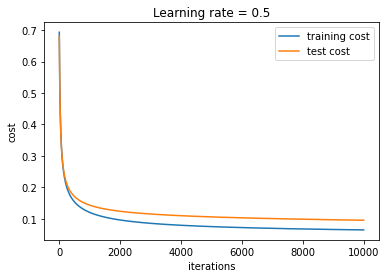

In [50]:
# Plot learning curve (with costs)
plt.plot(training_costs, label="training cost")
plt.plot(test_costs, label="test cost")
plt.legend()
plt.ylabel("cost")
plt.xlabel("iterations")
plt.title("Learning rate = " + str(learning_rate))
plt.show()

In [51]:
def predict(parameters: Dict, X: np.array) -> np.array:
    """
    This function created to predict class of each sample  by using given parameters.

    Args:
    parameters: python dictionary containing weights and bias.
    X -- input data. Shape = (num_features, num_samples)

    Returns
    (np.array) -- Array of predictions of our model. 0s for benings and 1s for malignants.
    """
    weights = parameters["weights"]
    bias = parameters["bias"]
    A = forward_propagation(weights, bias, X)
    predictions = np.where(A >= 0.5, 1, 0)
    return predictions

# Results

In [52]:
Y_prediction_test = predict(parameters, X_test)
print(
    "test accuracy: {} %".format(
        100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100
    )
)

test accuracy: 98.24561403508773 %


In [53]:
conf_matrix = confusion_matrix(Y_test, Y_prediction_test.reshape(-1))
TN, FP, FN, TP = conf_matrix.ravel()
print(f"True Positive: {TP}")
print(f"True Negative: {TN}")
print(f"False Positive: {FP}")
print(f"False Negative: {FN}")

True Positive: 26
True Negative: 86
False Positive: 2
False Negative: 0


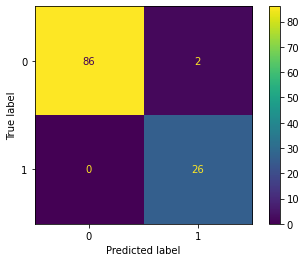

In [54]:
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()
plt.show()

In [55]:
classification_rep = classification_report(Y_test, Y_prediction_test.reshape(-1))
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        88
           1       0.93      1.00      0.96        26

    accuracy                           0.98       114
   macro avg       0.96      0.99      0.98       114
weighted avg       0.98      0.98      0.98       114



# Conclusion
In this example, we saw how to build a single-neuron learning algorithm for logistic regression problems from start to end. The dataset we chose was not difficult to classify and our model was able to learn it very well. If we look at the results, it is very important that the false_negative value is 0 because telling a cancer patient that they do not have cancer can be fatal.  On the other hand, our classifier diagnosed 2 patients who did not have cancer with cancer. This is an undesirable result. However, if we look at the total accuracy values, this algorithm, which we worked with a single neuron and limited data, was quite successful. You can test this algorithm for your other logistic regression problems.